В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [1]:
import joblib
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, TargetEncoder
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings("ignore")

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("drive/MyDrive/ML_Course/Data/churn_prediction/train.csv", index_col=0)

In [4]:
df.head(5)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [5]:
df.shape

(15000, 13)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 0 to 14999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       15000 non-null  float64
 1   Surname          15000 non-null  object 
 2   CreditScore      15000 non-null  float64
 3   Geography        15000 non-null  object 
 4   Gender           15000 non-null  object 
 5   Age              15000 non-null  float64
 6   Tenure           15000 non-null  float64
 7   Balance          15000 non-null  float64
 8   NumOfProducts    15000 non-null  float64
 9   HasCrCard        15000 non-null  float64
 10  IsActiveMember   15000 non-null  float64
 11  EstimatedSalary  15000 non-null  float64
 12  Exited           15000 non-null  float64
dtypes: float64(10), object(3)
memory usage: 1.6+ MB


Набір даних не містить пропущених даних, типи даних є логічними для кожної змінної (окрім CustomerID), проте, оскільки немає сенсу подавати цю змінну в модель, то і змінювати її тип даних також немає сенсу.

In [7]:
df['Exited'].value_counts(normalize=True)

,proportion
Exited,
0.0,0.796533
1.0,0.203467


Оскільки присутній дисбаланс класів таргет змінної, при розділенні на train та val сети краще використати параметер stratify=df['Exited'], щоб зберегти схожий розподіл таргет змінної в обох семплах.

In [8]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Exited'])

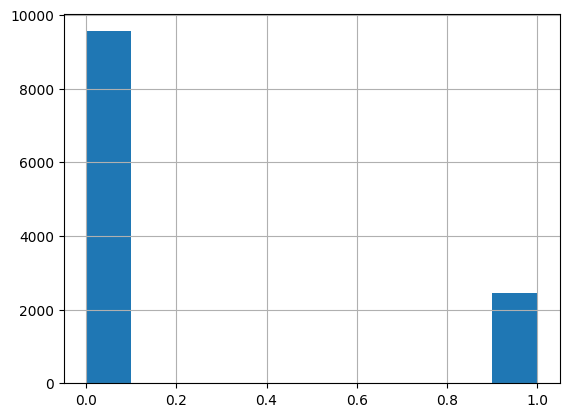

In [9]:
train_df['Exited'].hist();

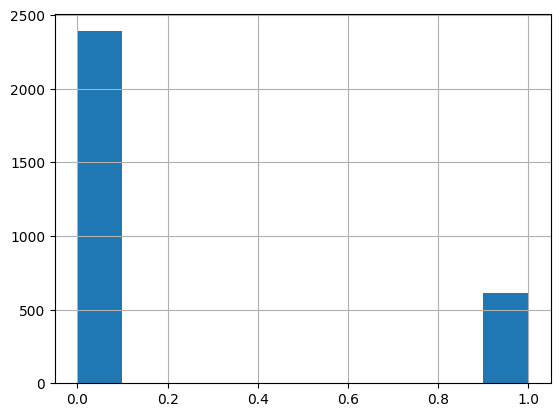

In [10]:
val_df['Exited'].hist();

2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [11]:
input_cols = list(train_df.columns)[2:-1]
target_col = 'Exited'

In [12]:
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]
val_inputs = val_df[input_cols]
val_targets = val_df[target_col]

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [13]:
numeric_cols = train_inputs.select_dtypes('number').columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

In [14]:
numeric_cols, categorical_cols

(['CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'],
 ['Geography', 'Gender'])

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [15]:
train_inputs.describe(percentiles=[.25, .5, .75, .9, .999])

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,658.840250,37.687917,5.026083,43008.174362,1.590250,0.790333,0.491583,117992.400015
std,72.334909,8.138440,2.781974,59906.627660,0.532646,0.407088,0.499950,45589.484607
min,431.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000
25%,603.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,83343.730000
50%,661.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,123613.910000
75%,708.000000,42.000000,7.000000,109949.050000,2.000000,1.000000,1.000000,156912.810000
90%,748.000000,48.000000,9.000000,134451.163000,2.000000,1.000000,1.000000,176570.550000
99.9%,850.000000,71.000000,10.000000,182026.199280,4.000000,1.000000,1.000000,199505.530000
max,850.000000,74.000000,10.000000,209767.310000,4.000000,1.000000,1.000000,199992.480000


З наведеної статистики можемо зазначити, що змінні CreditScore, Age, Tenure, NumOfProducts, HasCrCard, IsActiveMember демонструють "адекватні" дані.  

Проте, змінні Balance та EstimatedSalary мають показники, які вказують на потенційні наявність викидів та/або ненормальний розподіл даних в цих змінних.  
Balance:  
- мінімальне значення та медіана = 0.00
- стандартне відхилення більше за середнє значення  

EstimatedSalary:  
- мінімальне значення виглядає критично маленьким, зогляду на значення середнього та стандартного відхилення.
- значення 25 персентилю також є значно більшим за мінімум.  

Подивимось більш детально на ці дві змінні.

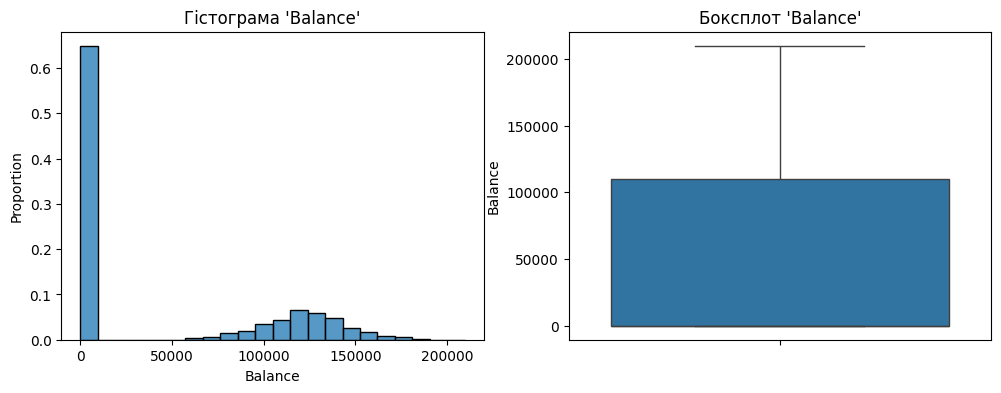

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12,4)
ax = sns.histplot(train_inputs, x='Balance', stat='proportion',  ax=axes[0])
axes[0].set_title("Гістограма 'Balance'")
ax = sns.boxplot(train_inputs, y='Balance', ax=axes[1])
axes[1].set_title("Боксплот 'Balance'");

Змінна Balance має приблизно 65% значень = 0.0  
При цьому частина, що відображає розподіл після значення 50000 має вигляд дуже схожий на нормальний.  
Маловирогідно, що нульові значення в змінній є помилками. Просто 65% клієнтів банку не мають грошей на рахунках.  
При цьому, відповідно до графіку boxplot розподіл не має явних викидів.  

Для подальших експериментів можемо використати наступні підходи:  
- ввести нову бінарну змінну на базі наявної hasBalance і знову натренувати модель, порівняти результати.  
- розділити датафрейм по значенням Balance до 50000 та більше 50000, натренувати модель на окремих даних і порівняти результати


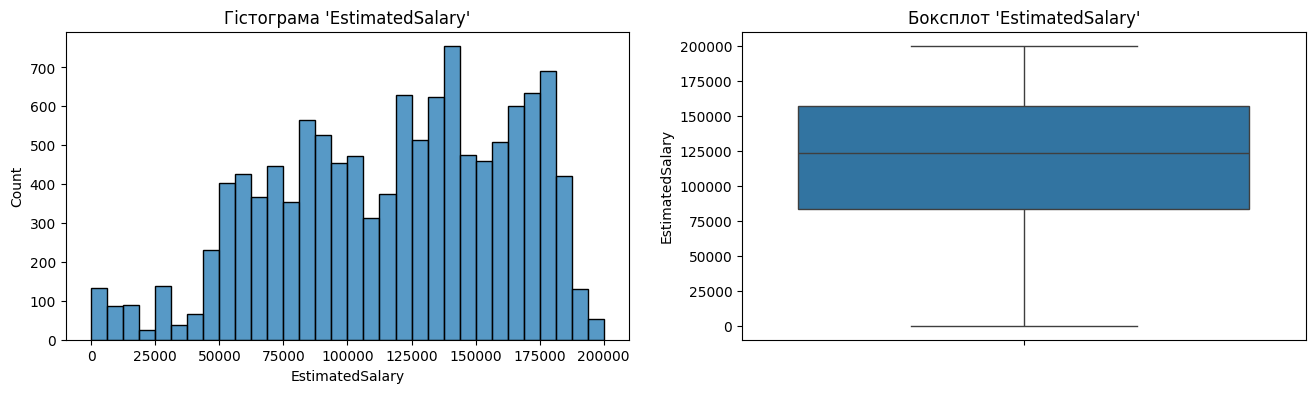

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(16,4)
ax = sns.histplot(train_inputs, x='EstimatedSalary',  ax=axes[0])
axes[0].set_title("Гістограма 'EstimatedSalary'")
ax = sns.boxplot(train_inputs, y='EstimatedSalary', ax=axes[1])
axes[1].set_title("Боксплот 'EstimatedSalary'");

Відповідно до графіків, розподіл змінної не містить викидів.

Оскільки змінні 'HasCrCard' та 'IsActiveMember' є бінарними і мають значення 0 або 1 немає сенсу їх масштабувати. Для всіх інших обираю MinMaxScaler оскільки він підходить і для змінних, які мають невелику кількість значень так і для змінних, розподіл яких не є нормальним і має перекоси.

In [18]:
scaled_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [19]:
scaled_columns = train_inputs[numeric_cols].drop(columns=['HasCrCard', 'IsActiveMember']).columns.tolist()

In [20]:
scaled_columns

['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [21]:
scaler = MinMaxScaler()

In [22]:
scaler.fit(train_inputs[scaled_cols])

MinMaxScaler()

In [23]:
train_inputs[scaled_cols] = scaler.transform(train_inputs[scaled_cols])
val_inputs[scaled_cols] = scaler.transform(val_inputs[scaled_cols])

In [24]:
train_inputs[numeric_cols].describe().round(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00
mean,0.54,0.35,0.50,0.21,0.20,0.79,0.49,0.59
std,0.17,0.15,0.28,0.29,0.18,0.41,0.50,0.23
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.41,0.25,0.30,0.00,0.00,1.00,0.00,0.42
50%,0.55,0.34,0.50,0.00,0.33,1.00,0.00,0.62
75%,0.66,0.43,0.70,0.52,0.33,1.00,1.00,0.78
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


Далі обробляємо категоріальні колонки

In [25]:
train_inputs[categorical_cols].nunique()

,0
Geography,3
Gender,2


Маємо всього 2 категоріальні змінні, з невеликою кількістю категорій.  
Змінна Gender має всього два значення і її буде доцільно закодувати з використанням LabelEncoder.  
Для Geography є сенс використати OneHotEncoder.

In [26]:
encoder_label = LabelEncoder()

In [27]:
label_cols = 'Gender'

In [28]:
encoder_label.fit(train_inputs[label_cols])

LabelEncoder()

In [29]:
label_encoded_cols = 'Gender_encoded'

In [30]:
train_inputs[label_encoded_cols] = encoder_label.transform(train_inputs[label_cols])
val_inputs[label_encoded_cols] = encoder_label.transform(val_inputs[label_cols])

In [31]:
target_encoder =TargetEncoder()

In [32]:
target_colums = 'Geography'
target_colums_encoded = 'Geography_encoded'
train_inputs['Geography_encoded'] = target_encoder.fit_transform(train_inputs[['Geography']], train_targets)
val_inputs['Geography_encoded'] = target_encoder.transform(val_inputs[['Geography']])

In [33]:
pd.set_option('display.max_columns', None)

In [34]:
display(train_inputs.head(5), val_inputs.head(5))

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_encoded,Geography_encoded
id,,,,,,,,,,,,
7180,0.599045,France,Male,0.214286,0.1,0.626382,0.000000,1.0,1.0,0.719772,1,0.161486
10393,0.603819,France,Female,0.375000,0.2,0.848836,0.000000,1.0,0.0,0.727603,0,0.157956
80,0.653938,Germany,Male,0.303571,0.6,0.554522,0.333333,1.0,0.0,0.872180,1,0.413530
3365,0.568019,Spain,Male,0.714286,0.0,0.000000,0.333333,0.0,1.0,0.257797,1,0.148204
12236,0.658711,France,Male,0.053571,0.3,0.000000,0.333333,1.0,1.0,0.742837,1,0.160375


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_encoded,Geography_encoded
id,,,,,,,,,,,,
6490,0.675418,Germany,Male,0.500000,0.1,0.551870,1.000000,1.0,1.0,0.364704,1,0.411292
3646,0.386635,France,Male,0.410714,0.5,0.000000,0.333333,1.0,1.0,0.190942,1,0.160177
5306,0.715990,France,Female,0.357143,0.2,0.000000,0.333333,0.0,1.0,0.584853,0,0.160177
652,0.577566,France,Female,0.446429,0.4,0.742441,0.000000,0.0,1.0,0.558109,0,0.160177
2627,0.589499,Spain,Female,0.214286,0.4,0.000000,0.333333,1.0,0.0,0.718420,0,0.152404


5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [35]:
#!pip install pyarrow --quiet

In [36]:
train_inputs.to_parquet('drive/MyDrive/ML_Course/Data/churn_prediction/train_inputs.parquet')
val_inputs.to_parquet('drive/MyDrive/ML_Course/Data/churn_prediction/val_inputs.parquet')
pd.DataFrame(train_targets).to_parquet('drive/MyDrive/ML_Course/Data/churn_prediction/train_targets.parquet')
pd.DataFrame(val_targets).to_parquet('drive/MyDrive/ML_Course/Data/churn_prediction/val_targets.parquet')

In [37]:
!ls drive/MyDrive/ML_Course/Data/churn_prediction

 churn_prediction.joblib		     submission_log_reg.csv
 churn_prediction_pipeline.joblib	     test.csv
 churn_prediction_pipeline_l2_c2.joblib      train.csv
 sample_submission.csv			     train_inputs.parquet
 submission_log_reg_2_degree_l2_c2_ros.csv   train_targets.parquet
 submission_log_reg_3_degree.csv	    'Untitled spreadsheet.gsheet'
 submission_log_reg_4_degree.csv	     val_inputs.parquet
 submission_log_reg_4_degree_l2_2.csv	     val_targets.parquet


6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [38]:
X_train = train_inputs[numeric_cols + [label_encoded_cols] + [target_colums_encoded]]
X_val = val_inputs[numeric_cols + [label_encoded_cols] + [target_colums_encoded]]

In [39]:
display(X_train.head(5), X_val.head(5))

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_encoded,Geography_encoded
id,,,,,,,,,,
7180,0.599045,0.214286,0.1,0.626382,0.000000,1.0,1.0,0.719772,1,0.161486
10393,0.603819,0.375000,0.2,0.848836,0.000000,1.0,0.0,0.727603,0,0.157956
80,0.653938,0.303571,0.6,0.554522,0.333333,1.0,0.0,0.872180,1,0.413530
3365,0.568019,0.714286,0.0,0.000000,0.333333,0.0,1.0,0.257797,1,0.148204
12236,0.658711,0.053571,0.3,0.000000,0.333333,1.0,1.0,0.742837,1,0.160375


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_encoded,Geography_encoded
id,,,,,,,,,,
6490,0.675418,0.500000,0.1,0.551870,1.000000,1.0,1.0,0.364704,1,0.411292
3646,0.386635,0.410714,0.5,0.000000,0.333333,1.0,1.0,0.190942,1,0.160177
5306,0.715990,0.357143,0.2,0.000000,0.333333,0.0,1.0,0.584853,0,0.160177
652,0.577566,0.446429,0.4,0.742441,0.000000,0.0,1.0,0.558109,0,0.160177
2627,0.589499,0.214286,0.4,0.000000,0.333333,1.0,0.0,0.718420,0,0.152404


In [40]:
model = LogisticRegression(solver='liblinear')

In [41]:
model.fit(X_train, train_targets)

LogisticRegression(solver='liblinear')

In [42]:
print(numeric_cols + [label_encoded_cols] + [target_colums_encoded])

['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Gender_encoded', 'Geography_encoded']


In [43]:
print(model.coef_.round(2).tolist())

[[-0.89, 8.39, -0.09, -0.92, -3.89, -0.19, -1.25, 0.17, -0.86, 5.57]]


In [44]:
print(model.intercept_)

[-3.48385275]


Отримані коефіцієнти показують, як змінюються лог-шанси кожного запису належати до позитивного класу при зміні відповідної змінної на 1.  
Можна побачити, що збільшення віку клієнта на 1 рік на 8.45 одиниць збільшує лог-шанси. У реальних шансах це вказує на значний вплив віку на ймовірність того, що клієнт припинить користуватися послугами банку.  
В свою чергу, збільшення кількості продуктів на 1, якими користується клієнт, зменшує шанси на 3.94 одиниць. У реальних шансах це свідчить, що клієнти, які користуються більше ніж одним продуктом банку, менш імовірно відмовляться від його послуг.  
Цікавим є той факт, що кількість років, що клієнт обслуговується в банку, має набагато менший вплив на зменшення шансів потрапити до позитивного класу.  
Також виглядає дивним, що збільшення значення EstimatedSalary збільшує шанси потрапити до позитивного класу.

Для більшої впевненості у впливі кожної змінної, розрахуємо p_value для кожної.

In [45]:
X_train_const = sm.add_constant(X_train)
logit_model = sm.Logit(train_targets, X_train_const)

In [46]:
results = logit_model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.319304
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 Exited   No. Observations:                12000
Model:                          Logit   Df Residuals:                    11989
Method:                           MLE   Df Model:                           10
Date:                Sat, 01 Feb 2025   Pseudo R-squ.:                  0.3680
Time:                        16:03:30   Log-Likelihood:                -3831.6
converged:                       True   LL-Null:                       -6062.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -3.8322      0.184    -20.849      0.000      -4.192      -3.472
CreditSc

Отже, отриманий результат підтверджує наше припущення, що змінні Tenure та EstimatedSalary не мають значущого впливу на результат. В подальших експериментах спробуємо не передавати ці змінні під час навчання і порівняємо метрики ефективності з нашою базовою моделлю, що навчена на всіх змінних.  
Перевіримо також наявність мультиколінеарності, розрахувавши кореляцію між змінними.

In [47]:
corr_train = X_train.corr()

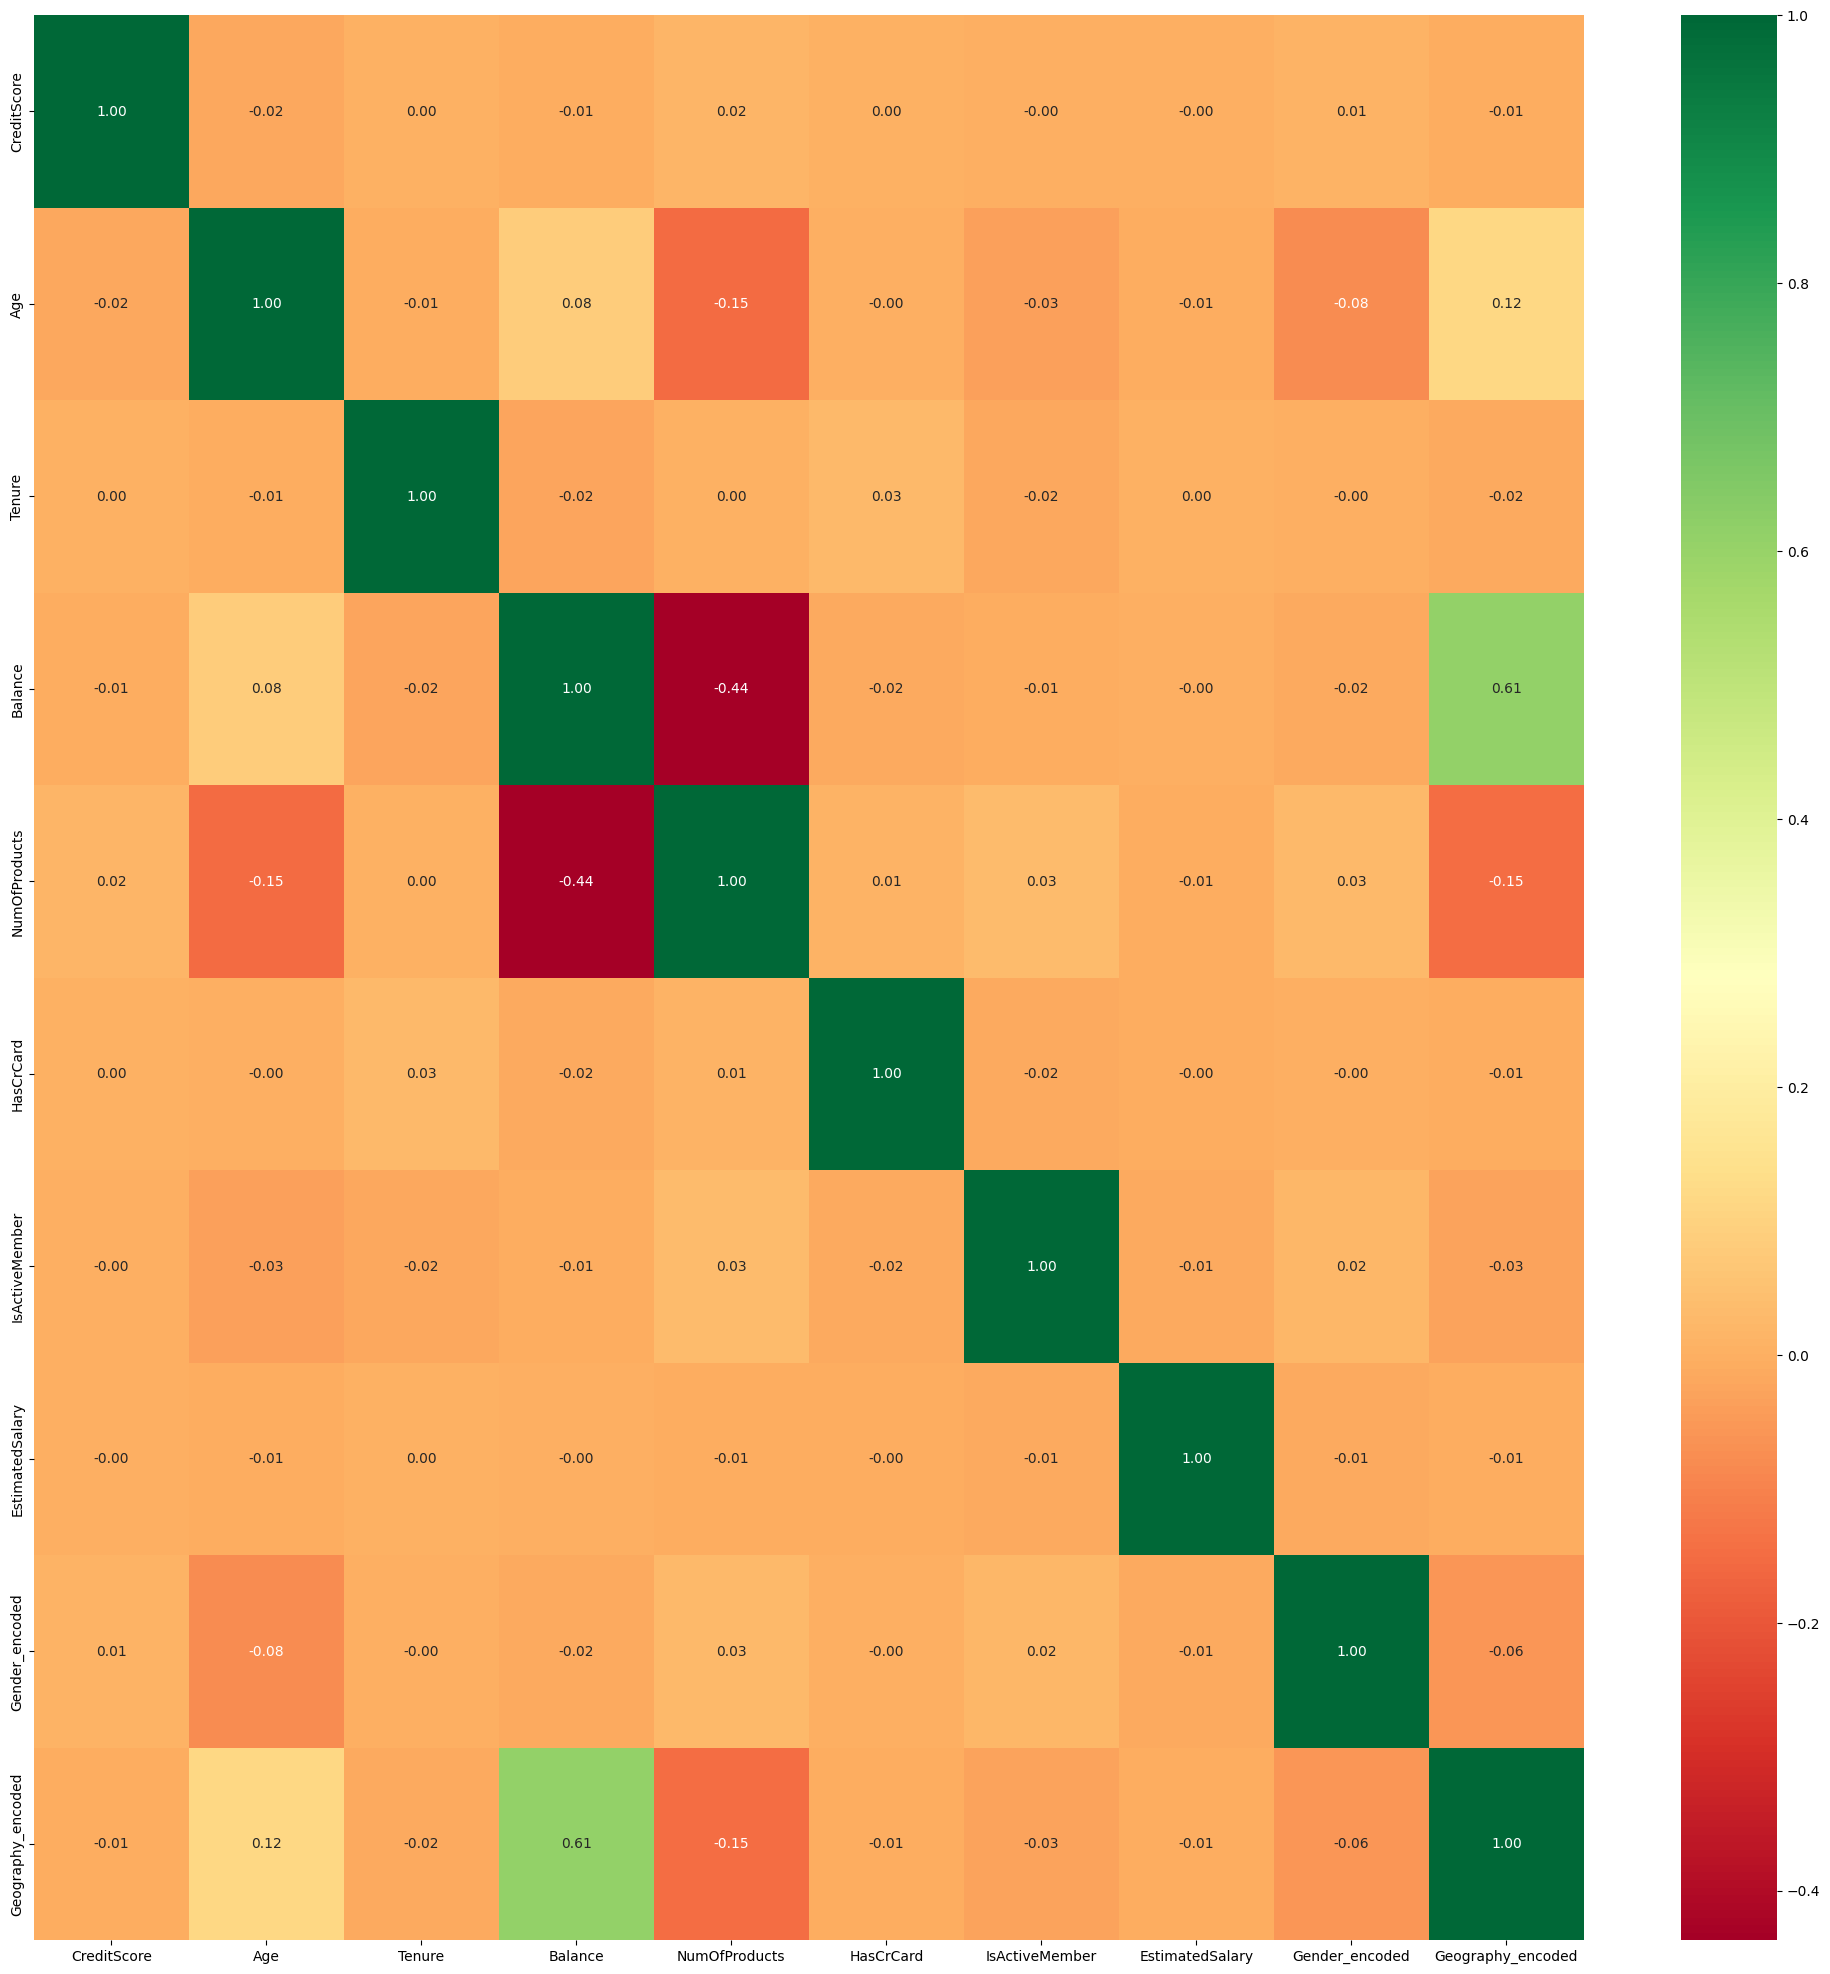

In [48]:
plt.figure(figsize = (25,25))
sns.heatmap(data = corr_train, annot = True, cmap = "RdYlGn", cbar = True, fmt='.2f')
plt.show();

Бачимо, що після застосування OneHotEncoding маємо високу кореляцію між новими закодованими змінними, що позначають регіон приживання клієнта. Для подальших експериментів доцільно використати параметр drop='first', щоб прибрати мультиколінеарність з моделі.

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [49]:
def predict_f1_matrix(inputs, targets, name=''):
    preds = model.predict(inputs)

    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))

    f1_score_ = f1_score(targets, preds)
    print(f"F1 score {name}: {f1_score_:.2f}%")

    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));

    return preds

Accuracy: 87.38%
F1 score Train: 0.63%


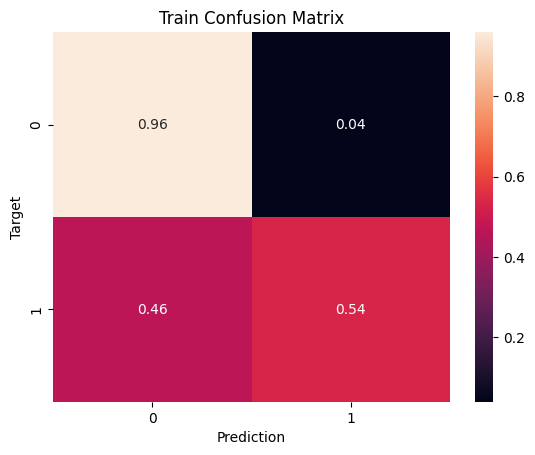

In [50]:
train_preds = predict_f1_matrix(X_train,train_targets, 'Train')

Accuracy: 87.13%
F1 score Validation: 0.64%


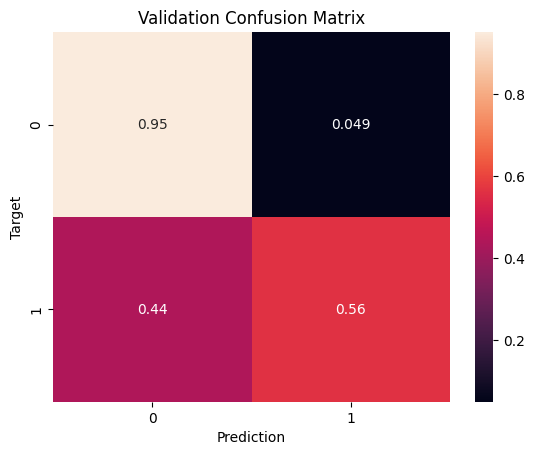

In [51]:
val_preds = predict_f1_matrix(X_val,val_targets, 'Validation')

In [52]:
def compute_auroc_and_build_roc(inputs, targets, name=''):
  # Predict probabilities
  y_pred_proba = model.predict_proba(inputs)[:, 1]

  # Compute ROC curve
  fpr, tpr, thresholds = roc_curve(targets, y_pred_proba)

    # Compute AUROC
  roc_auc = auc(fpr, tpr)
  print(f'AUROC for {name}: {roc_auc:.2f}')

  # Plot the ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
  plt.legend(loc="lower right")
  plt.show()

AUROC for Train: 0.88


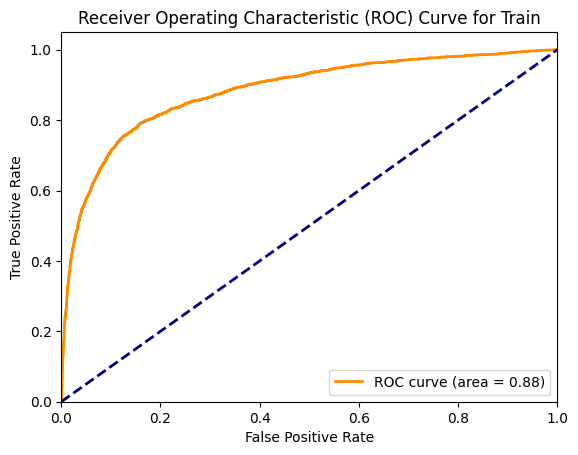

In [53]:
compute_auroc_and_build_roc(X_train,train_targets, 'Train')

AUROC for Validation: 0.88


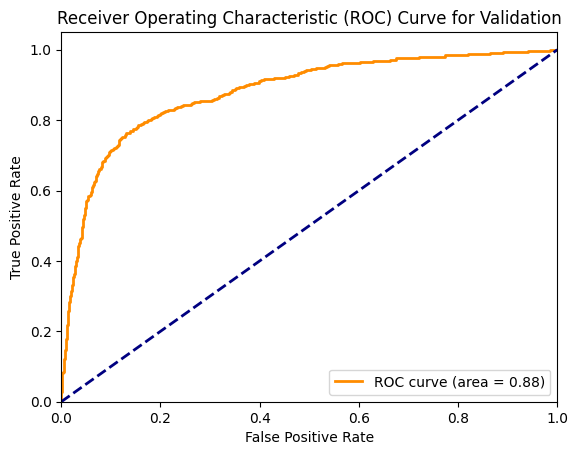

In [54]:
compute_auroc_and_build_roc(X_val,val_targets, 'Validation')

**Висновок:**  
Модель показала майже однакові результати оцінок ефективності, отже, це означає, що вона на однаковому рівні працює як з тренувальними даними, так і з новими даними, які модель до цього не бачила.  
AU ROC = 0.88 - це достатньо високий показник, який показує, що модель достатньо добре виокремлює класи.  
На Confusion Matrix ми бачимо, що модель добре передбачає клієнтів, що належать до негативного класу (0) True Negatives = 0.96 / 0.95 - тих, що залишатимуться клієнтами банку.   Випадки, коли модель помилково визначила клієнтів, що залишатимуться клієнтами банку, хоча це насправді не так (False Positives) - 4% та 5% відповідно.  
Проте, модель демонструє значно гірший показник False Negatives = 0.46 / 0.44, коли модель помилково віднесла до негативного класу тих клієнтав, що насправді перестали бути клієнтами банку. Враховуючи, що точність саме по негативному класу є для нас пріоритетною, цей показник є занадто високим і модель потребує вдосконалення, що допоможе зменшити його.  
Відповідно, кількість правильних передбачень належності клієнта до негативного класу True Positives = 0.54 / 0.56.

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [55]:
train_targets.value_counts(normalize=True)

,proportion
Exited,
0.0,0.7965
1.0,0.2035


In [56]:
def all_zero(inputs):
    return np.full(len(inputs), 0)

Accuracy: 85.93%
F1 score : 0.00%


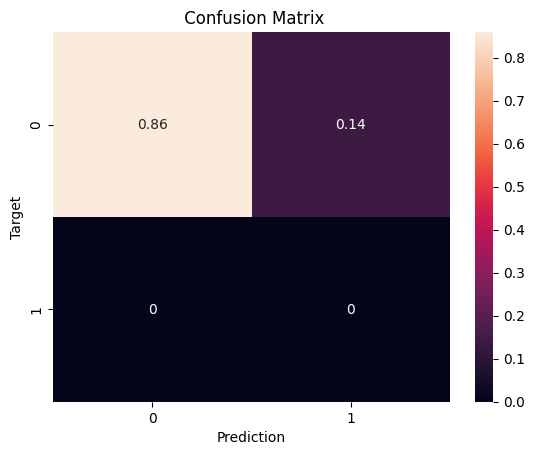

In [57]:
custom_train_preds = predict_f1_matrix(X_train, all_zero(X_train))

Accuracy: 84.67%
F1 score : 0.00%


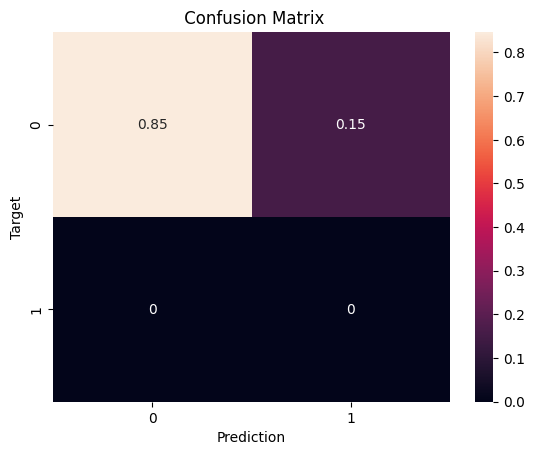

In [58]:
custom_val_preds = predict_f1_matrix(X_val, all_zero(X_val))

Accuracy для тренувальних та валідаційних даних базової моделі достатньо висока, проте:  
1. Значення менше ніж у попередньої моделі на обох сетах  
2. Високе значення Accuracy для базової моделі пояснюється тим, що ми створили її на підставі домінуючого класу. А отже, чим більше у нас негативного класу в датасетах, тим більше значення Accuracy ми отримуємо.  


9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [59]:
churn_prediction = {
    'model': model,
    'scaler': scaler,
    'encoder_label': encoder_label,
    'encoder_one_hot': target_encoder,
    'input_cols': input_cols,
    'target_col': target_colums,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'scaled_cols': scaled_cols,
    'label_cols': label_cols,
    'one_hot_cols': target_colums,
    'label_encoded_cols': label_encoded_cols,
    'one_hot_encoded_cols': target_colums_encoded
}

In [60]:
joblib.dump(churn_prediction, 'drive/MyDrive/ML_Course/Data/churn_prediction/churn_prediction.joblib')

['drive/MyDrive/ML_Course/Data/churn_prediction/churn_prediction.joblib']

In [61]:
churn_prediction2 = joblib.load('drive/MyDrive/ML_Course/Data/churn_prediction/churn_prediction.joblib')
model_2 = churn_prediction2['model']

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [62]:
def predict_raw_df(scaler, label_encoder, target_encoder, numeric_cols, scaled_cols, label_cols, label_encoded_cols, target_colums, target_colums_encoded, input_df: pd.DataFrame):
    input_df[scaled_cols] = scaler.transform(input_df[scaled_cols])
    input_df[label_encoded_cols] = label_encoder.transform(input_df[label_cols])
    input_df[target_colums_encoded] = target_encoder.transform(input_df[[target_colums]])
    X_input = input_df[numeric_cols + [label_encoded_cols] + [target_colums_encoded]]
    prob = model.predict_proba(X_input)[:,1]
    return prob

In [63]:
predict_raw_df(scaler, encoder_label, target_encoder, numeric_cols, scaled_cols, label_cols, label_encoded_cols, target_colums, target_colums_encoded, df[:5])

array([0.00665765, 0.0376687 , 0.37042688, 0.3491835 , 0.97305862])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [64]:
test_raw_df = pd.read_csv("drive/MyDrive/ML_Course/Data/churn_prediction/test.csv", index_col=0)

In [65]:
test_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 15000 to 24999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  float64
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  float64
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  float64
 6   Tenure           10000 non-null  float64
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  float64
 9   HasCrCard        10000 non-null  float64
 10  IsActiveMember   10000 non-null  float64
 11  EstimatedSalary  10000 non-null  float64
dtypes: float64(9), object(3)
memory usage: 1015.6+ KB


In [66]:
test_raw_df['Exited'] = predict_raw_df(scaler,
                                       encoder_label,
                                       target_encoder,
                                       numeric_cols,
                                       scaled_cols,
                                       label_cols,
                                       label_encoded_cols,
                                       target_colums,
                                       target_colums_encoded,
                                       test_raw_df)

12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [67]:
sample_submission = pd.read_csv("drive/MyDrive/ML_Course/Data/churn_prediction/sample_submission.csv", index_col=0)

In [68]:
sample_submission['Exited'] = test_raw_df['Exited'].values

In [69]:
sample_submission.head(5)

,Exited
id,
15000,0.072093
15001,0.035851
15002,0.151090
15003,0.198904
15004,0.058079


In [70]:
sample_submission.reset_index().to_csv("drive/MyDrive/ML_Course/Data/churn_prediction/submission_log_reg.csv", index=False)